In [11]:
# common
import os 
import keras
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from numpy import zeros
from numpy.random import randint

# Data
from tensorflow.image import resize
from tensorflow.keras.utils import load_img, img_to_array

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.layers import add
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import multiply
from keras.layers import concatenate
from keras.layers import Conv2DTranspose
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout

# Model Functions
from keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.callbacks import Callback, ModelCheckpoint

In [13]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


# **Data**

Loading the data.

In [23]:
def load_image(path):
    img = resize(img_to_array(load_img(path))/255., (256,256))
    return img

In [24]:
image_path = "/home/msccomputer/Desktop/Water_dataset/train/images"
total_images = len(os.listdir(image_path))
print(f"Total Number of Images : {total_images}")

Total Number of Images : 1526


In [25]:
all_image_paths = sorted(glob(image_path + "/*"))

In [26]:
def load_data(paths):
    images = zeros(shape=(len(paths), 256,256,3))
    masks = zeros(shape=(len(paths), 256,256,3))
    for i, path in tqdm(enumerate(paths), desc="Loading"):
        image = load_image(path)
        images[i] = image
        
        mask_path = path.replace("images", "annotations")
        mask = load_image(mask_path)
        masks[i] = mask
    return images, masks

In [27]:
train_paths = all_image_paths
X_train, y_train = load_data(train_paths)

Loading: 1526it [00:41, 36.34it/s]


In [28]:
val_image_path = "/home/msccomputer/Desktop/Water_dataset/val/images"
total_images = len(os.listdir(val_image_path))
print(f"Total Number of Images : {total_images}")

Total Number of Images : 217


In [29]:
val_image_paths = sorted(glob(val_image_path + "/*"))

In [30]:
val_paths = val_image_paths
X_val, y_val = load_data(val_paths)

Loading: 217it [00:04, 53.71it/s]


# **Data Viz**

In [32]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [ ]:
for i in range(10):
    id = randint(1000)
    image, mask = X_train[id], y_train[id]
    plt.figure(figsize=(10,8))
    
    plt.subplot(1,2,1)
    show_image(image, title="Image")
    
    plt.subplot(1,2,2)
    show_image(mask, title="Mask")
    
    plt.tight_layout()
    plt.show()

By looking at the data we can say that this problem can easily be **generalized by an UNet Model**

# **UNet - Encoder**

**Encoder** reduced the **size of its inputs by 2**. The **ideology** behind **encoder* is that it will learn the **most useful features** present in the **image**, and the **last encoding layer** will be full of the **important features only**, also called as the **latent representations**.

In [6]:
class Encoder(Layer):
    
    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.bn = BatchNormalization()
        self.c1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")
        self.pool = MaxPool2D()
        
    def call(self, X):
        x = self.bn(X)
        x = self.c1(x)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x
            
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

# **UNet - Decoder**

As the name suggests, the **Decoder** is just the **opposite of the encoder**, which will **upscale its inputs by 2**. The input to the decoder are the **latent representations** produced by the **encoder**. This means that the **decoder only has access** to the **most useful features**, thus allowing the decoder to focus on **recreating the image** from the **most useful features**. This time the **decoder also takes inputs** from the **encoder** this helps the **decoder to preserve the spatial information** of the **original image**.

In [7]:
class Decoder(Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.bn = BatchNormalization()
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer="he_normal")
        self.net = Encoder(filters, rate, pooling=False)
        
    def call(self, X):
        x, skip_x = X
        x = self.bn(x)
        x = self.cT(x)
        x = concatenate([x, skip_x])
        x = self.net(x)
        return x
            
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
        }

# **UNet - Architecture**

We have our **encoder, decoder ready**. It's time to combine all of them to make a **UNet Model**.

In [8]:
# Inputs
unet_inputs = Input(shape=(256,256,3), name="UNetInput")

# Encoder Network : Downsampling phase
p1, c1 = Encoder(64, 0.1, name="Encoder1")(unet_inputs)
p2, c2 = Encoder(128, 0.1, name="Encoder2")(p1)
p3, c3 = Encoder(256, 0.2, name="Encoder3")(p2)
p4, c4 = Encoder(512, 0.2, name="Encoder4")(p3)


# Encoding Layer : Latent Representation
e = Encoder(512, 0.3, pooling=False)(p4)

# Attention + Decoder Network : Upsampling phase.
d1 = Decoder(512, 0.2, name="Decoder1")([e, c4])
d2 = Decoder(256, 0.2, name="Decoder2")([d1, c3])
d3 = Decoder(128, 0.1, name="Decoder3")([d2, c2])
d4 = Decoder(64, 0.1, name="Decoder4")([d3, c1])

# Output
unet_out = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(d4)

# Model
UNet = Model(
    inputs=unet_inputs,
    outputs=unet_out,
    name="AttentionUNet"
)

# Compiling
UNet.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

# **UNet - Visualization**

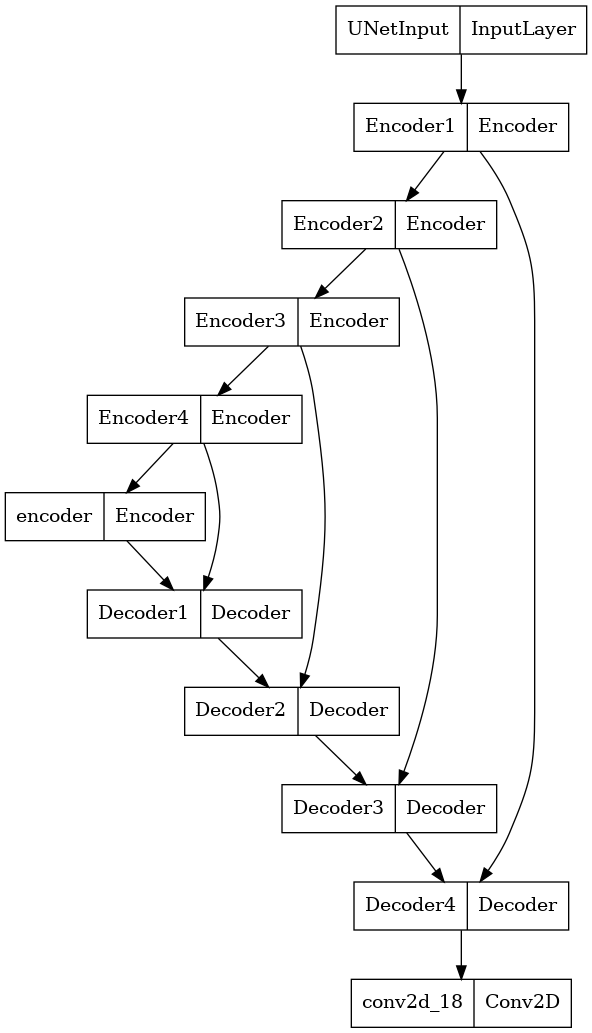

In [37]:
plot_model(UNet, "UNet-WaterBody.png", show_shapes=False)

# **Training**

In [38]:
BATCH_SIZE = 16
SPE = len(X_train)//BATCH_SIZE

In [39]:
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        id = randint(len(X_val))
        image = X_val[id]
        mask = y_val[id]
        pred_mask = self.model(tf.expand_dims(image,axis=0))[0]
        
        plt.figure(figsize=(10,8))
        plt.subplot(1,3,1)
        show_image(image, title="Original Image")
        
        plt.subplot(1,3,2)
        show_image(mask, title="Original Mask")
        
        plt.subplot(1,3,3)
        show_image(pred_mask, title="Predicted Mask")
            
        plt.tight_layout()
        plt.show()

In [40]:
cbs = [
    ModelCheckpoint("UNet-WaterBodySegmentation.h5", save_best_only=True),
    ShowProgress()
]

In [ ]:
UNet.fit(
    X_train, y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    steps_per_epoch=SPE,
    validation_data=(X_val, y_val),
    callbacks=cbs
)

The **Model** gradually got improved over the course of training. The model could be **even better** with **more training**.

In [9]:
Unet = keras.models.load_model('/home/msccomputer/catkin_ws/src/msc_thesis/train_segmentation/UNet-WaterBodySegmentation.h5')


for i in range(20):
    id = randint(len(X_val))
    image = X_val[id]
    mask = y_val[id]
    pred_mask = UNet.predict(tf.expand_dims(image,axis=0))[0]
    post_process = (pred_mask[:,:,0] > 0.5).astype('int')
        
    plt.figure(figsize=(10,8))
    plt.subplot(1,4,1)
    show_image(image, title="Original Image")
        
    plt.subplot(1,4,2)
    show_image(mask, title="Original Mask")
        
    plt.subplot(1,4,3)
    show_image(pred_mask, title="Predicted Mask")
    
    plt.subplot(1,4,4)
    show_image(post_process, title="Post=Processed Mask")
    
    
    plt.tight_layout()
    plt.show()

ValueError: Unknown layer: 'Encoder'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

The model easily **segments water** when the **water is present at natural locations** but it **gets confused** when the water is present at **artificial locations**.

* I tried out **Attention UNet** but it **doesn't seems to work well**.

**Thank You!!!**

---
**DeepNets**